# Investigating Carbon Emissions of Neutron Transport Simulations.
Rosie Schiffmann <br>
University of Manchester <br>
July 2025

# 1. Introduction
In this notebook, the carbon emissions produced by running some neutron transport simulation software is plotted. The software used is found inside "Project_3_11020606.ipynb", where CodeCarbon is implemented to track and export data about the energy consumption of simulating transmission, reflection and absortion rates of neutrons incident onto different thicknesses of lead, graphite and water "slabs". The simulation complexity is increased by increasing the number of neutrons incident onto the slabs.

CodeCarbon is an embedded package that can be used to estimate the carbon footprint (alongside other power and energy metrics) of your software. If it has access to RAPL files from on-chip sensors, this data is used to calculate the energy used by the CPU during computation. However if there is no access to RAPL (due to non-Linux OS, non-Intel CPU), the thermal design power (TDP) of the CPU is found from a database and approximated as an effective constant power draw. The energy consumption of a Nvidia GPU can be calculated from NVML files, and the RAM energy can be approximated by a standard power draw of 0.375W per GB of memory. The emissions are calculated by multiplying the total energy consumption by the carbon intensity in your location at runtime.

In this investigation, CodeCarbon was used to evalutate emissions of the `plot_T_A_R_thicknesses` function inside of the `Project_3_11020606.ipynb` notebook. This software has been run on an Acer Aspire 5 laptop, with a 12th Gen Intel(R) Core(TM) i5-1235U CPU. This laptop is run on Windows OS, with no access to RAPL files. Therefore, CodeCarbon falls back to "machine" mode, using a global TDP of 85W, with a 50% usage factor. This leads to a constant power draw of 42.5W being used during CPU energy consumpion analysis. For RAM energy consumption, a constant power draw fallback method is also used to keep energy evaluation models constant. RAM power is estimated to be 10W. GPU data is not available, as the laptop does not contain its own GPU, but an intergrated Intel iRIS Xe GPU. 

 Various plots are investigated to demonstrate that:
- power is constant no matter what you're doing 
- energy consumption increases with time 
- energy consumption scales with simulation complexity in the way that we expect 

In [405]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 2. Data 
Inside "Project_3_11020606.ipynb", CodeCarbon is implemented to measure the energy consumption of the `plot_T_A_R_thicknesses` function as follows:
```
from codecarbon import EmissionsTracker
with EmissionsTracker(output_file="210725_neutron_penetration_emissions_100000.csv") as tracker:
    transmission_master_array, transmission_errors_master_array = plot_T_A_R_thicknesses(
        thicknesses, 100000, mfp_total, prob_absorb)
print("=====done=====") 
```

Each time this cell is run, a new row of CodeCarbon output data is added to the corresponding `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` file. Each row contains data on emissions, duration, cpu_power, ram_power, gpu_power, cpu_energy, ram_energy, gpu_energy and others.

Below, all of the `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` files inside the repository that match a given date are collected. The mean values for emissions, duration, CPU/GPU power and CPU/GPU energy are calculated for each selected file, and the number of neutrons in the simulation is extracted from the filename. The corresponding error on the mean is also propagated for each value. All of this data, as well as some per-neutron metrics, are added to a `"master_emissions_data.csv"` file, with each row corresponding to processed data from a different `"XXXXXX_neutron_penetration_emissions_XXXXX.csv"` file.

In [406]:
#identify relevant csv files inside repository
csv_files = glob.glob("210725_neutron_penetration_emissions_*.csv")

summary_data = []

for file in csv_files:
    #identify and find mean of relevant data from CodeCarbon raw outputs
    df = pd.read_csv(file)
    mean_emissions = df['emissions'].mean()
    mean_duration = df['duration'].mean()
    mean_cpu_power = df['cpu_power'].mean()
    mean_ram_power = df['ram_power'].mean()
    mean_cpu_energy = df['cpu_energy'].mean()
    mean_ram_energy = df['ram_energy'].mean()
    #obtain number of neutrons from filename
    match = re.search(r'neutron_penetration_emissions_(\d+)\.csv', file)
    neutrons = int(match.group(1)) if match else None

    #propagate errors
    emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
    duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
    cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
    ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
    cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
    ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
    
    #add dictionary of data to summary_data list 
    summary_data.append({
        'filename': file,
        'number_of_neutrons': neutrons,
        'mean_emissions': mean_emissions,
        'emissions_err' : emissions_err,
        'mean_duration': mean_duration,
        'duration_err' : duration_err,
        'mean_cpu_power': mean_cpu_power,
        'cpu_power_err' : cpu_power_err,
        'mean_ram_power' : mean_ram_power,
        'ram_power_err' : ram_power_err,
        'mean_cpu_energy' : mean_cpu_energy,
        'cpu_energy_err' : cpu_energy_err,
        'mean_ram_energy' : mean_ram_energy,
        'ram_energy_err' : ram_energy_err,
        'cpu_energy_per_neutron' : mean_cpu_energy / neutrons,
        'cpu_energy_per_neutron_err' : cpu_energy_err / neutrons,
        'ram_energy_per_neutron' : mean_ram_energy / neutrons,
        'ram_energy_per_neutron_err' : ram_energy_err / neutrons,
        'duration_per_neutron' : mean_duration / neutrons,
        'duration_per_neutron_err': duration_err / neutrons
    })

#convert into dataframe and create master csv file.
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("master_emissions_data.csv", index=False)


Below, we will format the master csv file "master_emissions_data.csv", which contains all the plotting data for each different simulation complexity. 
- "number_of_neutrons" represents the number of neutrons incident onto the slab.
- "mean_emissions" is the average gCO2e emitted by running the simulation for that number of neutrons, with associated error on the mean "emissions_err".
- "mean_duration" is the average runtime of the simulation in seconds, with associated error on the mean "duration_err".
- "mean_cpu_power" represents the average power used by the CPU during the simulation in Watts, with associated error on the mean "cpu_power_err".
- "mean_ram_power" represents the average power used by RAM during the simulation in Watts, with associated error on the mean "ram_power_err".
- "mean_cpu_energy" represents the average energy used by the CPU during the simulation in Joules, with associated error on the mean "cpu_energy_err".
- "mean_ram_energy" represents the average energy used by RAM during the simulation in Joules, with associated error on the mean "ram_energy_err".

NOTE: mean_cpu_power is exactly constant, as CodeCarbon doesn't have access to RAPL on Windows OS, so it falls back on constant Thermal Design Power (TDP).

In [407]:
#load master_emissions_data.csv into a dataframe, and display it
df = pd.read_csv("master_emissions_data.csv")
df

,filename,number_of_neutrons,mean_emissions,emissions_err,mean_duration,duration_err,mean_cpu_power,cpu_power_err,mean_ram_power,ram_power_err,mean_cpu_energy,cpu_energy_err,mean_ram_energy,ram_energy_err,cpu_energy_per_neutron,cpu_energy_per_neutron_err,ram_energy_per_neutron,ram_energy_per_neutron_err,duration_per_neutron,duration_per_neutron_err
0,210725_neutron_penetration_emissions_10000.csv,10000,0.000023,0.000006,11.020951,0.072334,42.5,0.0,10.0,0.0,0.000130,8.532727e-07,0.000031,2.007355e-07,1.300865e-08,8.532727e-11,3.059400e-09,2.007355e-11,0.001102,0.000007
1,210725_neutron_penetration_emissions_100000.csv,100000,0.000176,0.000045,78.801818,5.905221,42.5,0.0,10.0,0.0,0.000930,6.963832e-05,0.000219,1.635841e-05,9.300189e-09,6.963832e-10,2.186769e-09,1.635841e-10,0.000788,0.000059
2,210725_neutron_penetration_emissions_20000.csv,20000,0.000067,0.000001,19.238290,0.292800,42.5,0.0,10.0,0.0,0.000227,3.458450e-06,0.000053,8.128814e-07,1.135228e-08,1.729225e-10,2.669232e-09,4.064407e-11,0.000962,0.000015
3,210725_neutron_penetration_emissions_35000.csv,35000,0.000105,0.000012,34.269162,1.352874,42.5,0.0,10.0,0.0,0.000404,1.596007e-05,0.000095,3.750929e-06,1.155564e-08,4.560019e-10,2.717285e-09,1.071694e-10,0.000979,0.000039
4,210725_neutron_penetration_emissions_50000.csv,50000,0.000049,0.000020,39.230612,4.494650,42.5,0.0,10.0,0.0,0.000463,5.300938e-05,0.000109,1.245825e-05,9.259731e-09,1.060188e-09,2.177278e-09,2.491650e-10,0.000785,0.000090
5,210725_neutron_penetration_emissions_60000.csv,60000,0.000039,0.000020,40.717637,0.263028,42.5,0.0,10.0,0.0,0.000481,3.100846e-06,0.000113,7.293803e-07,8.010137e-09,5.168077e-11,1.883829e-09,1.215634e-11,0.000679,0.000004
6,210725_neutron_penetration_emissions_70000.csv,70000,0.000134,0.000023,51.211801,0.808362,42.5,0.0,10.0,0.0,0.000604,9.537780e-06,0.000142,2.241378e-06,8.634673e-09,1.362540e-10,2.030348e-09,3.201968e-11,0.000732,0.000012
7,210725_neutron_penetration_emissions_80000.csv,80000,0.000074,0.000030,52.594184,0.121813,42.5,0.0,10.0,0.0,0.000621,1.443016e-06,0.000146,3.396416e-07,7.759745e-09,1.803769e-11,1.824903e-09,4.245520e-12,0.000657,0.000002
8,210725_neutron_penetration_emissions_90000.csv,90000,0.000022,0.000020,58.486795,0.157499,42.5,0.0,10.0,0.0,0.000690,1.861336e-06,0.000162,4.370796e-07,7.670503e-09,2.068151e-11,1.804000e-09,4.856440e-12,0.000650,0.000002


# 2. Plotting

In [408]:
def reduced_chi_squared(x, y, y_err, coeffs):
    """
    Calculate the reduced chi-squared for a polynomial fit.

    Parameters:
    - x: 1d array, x-values
    - y: 1d array, observed y-values
    - y_err: 1d array, uncertainties in y
    - coeffs: 1d array, polynomial coefficients from np.polyfit()

    Returns:
    - chi_squared_reduced: float
    """
    model = np.poly1d(coeffs)
    residuals = (y - model(x)) / y_err
    chi_squared = np.sum(residuals**2)
    dof = len(x) - len(coeffs)  # degrees of freedom = N - (fit order + 1)
    return chi_squared / dof


def CPU_and_RAM_plotting(df, x_variable, CPU_y_variable, CPU_y_err, RAM_y_variable, RAM_y_err, fit=False, fit_order=None):
    """
    Creates 2 plots (one for CPU and one for RAM), with axis defined by argumants. An optional polyfit is applied and reduced chi squared
    calculated.

    Parameters: 
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable for plotting from dataframe
    - CPU_y_variable: string, name of y-axis variable for CPU plot from dataframe
    - CPU_y_err: string, name of error associated with CPU y-axis variable from dataframe
    - RAM_y_variable: string, name of y-axis variable for RAM plot from dataframe
    - RAM_y_err: string, name of error associated with RAM y-axis variable from dataframe
    - fit: bool, whether or not plot should have fitting
    - fit_order: int, order of fit if fit=True
    """
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)

    #define units of selected variables, with default as no units
    units = ['J', 'gCO2e', 's', 'W', '']
    if x_variable=='mean_duration': x_unit=2
    elif x_variable=='number_of_neutrons': x_unit=4
    else: x_unit=4

    if CPU_y_variable=="mean_cpu_energy": y_unit=0
    elif CPU_y_variable=="cpu_energy_per_neutron": y_unit=0
    elif CPU_y_variable=="mean_cpu_power":y_unit=3
    elif CPU_y_variable=="mean_emissions": y_unit=1
    else: y_unit=4
    
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        #CPU data fitting
        if np.any(df[CPU_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order)
        else:
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order, w=1/df[CPU_y_err])
        poly_cpu = np.poly1d(coeffs_cpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        CPU_chi = reduced_chi_squared(df[x_variable], df[CPU_y_variable], df[CPU_y_err], coeffs_cpu)
        ax[0].plot(x_fit, poly_cpu(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {CPU_chi:.2g}", linewidth = 0.5)
        

        #RAM data fitting
        if np.any(df[RAM_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order)
        else:
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order, w=1/df[RAM_y_err])
        poly_ram = np.poly1d(coeffs_ram)
        RAM_chi = reduced_chi_squared(df[x_variable], df[RAM_y_variable], df[RAM_y_err], coeffs_ram)
        ax[1].plot(x_fit, poly_ram(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {RAM_chi:.2g}", linewidth = 0.5)

    #plotting CPU data
    ax[0].errorbar(df[x_variable], df[CPU_y_variable], yerr = df[CPU_y_err], fmt = "none", capsize = 2, label = "CPU data (Intel Core i5-1235U CPU. 42.5W power-draw)")
    ax[0].set_title(f'{CPU_y_variable} vs {x_variable}')
    ax[0].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[0].set_ylabel(f'{CPU_y_variable}, {units[y_unit]}')

    #plotting RAM data
    ax[1].errorbar(df[x_variable], df[RAM_y_variable], yerr = df[RAM_y_err], fmt = "none", capsize = 2, label = "RAM data (7.711 GB available. 10W power draw)")
    ax[1].set_title(f'{RAM_y_variable} vs {x_variable}')
    ax[1].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[1].set_ylabel(f'{RAM_y_variable}, {units[y_unit]}')

    #plot details
    for i in range(2):
        ax[i].grid()
        ax[i].legend()
    return None   

# 2.1 Energy consumption
Here, we demonstrate that energy consumption increases linearly with run-time of the simulation.

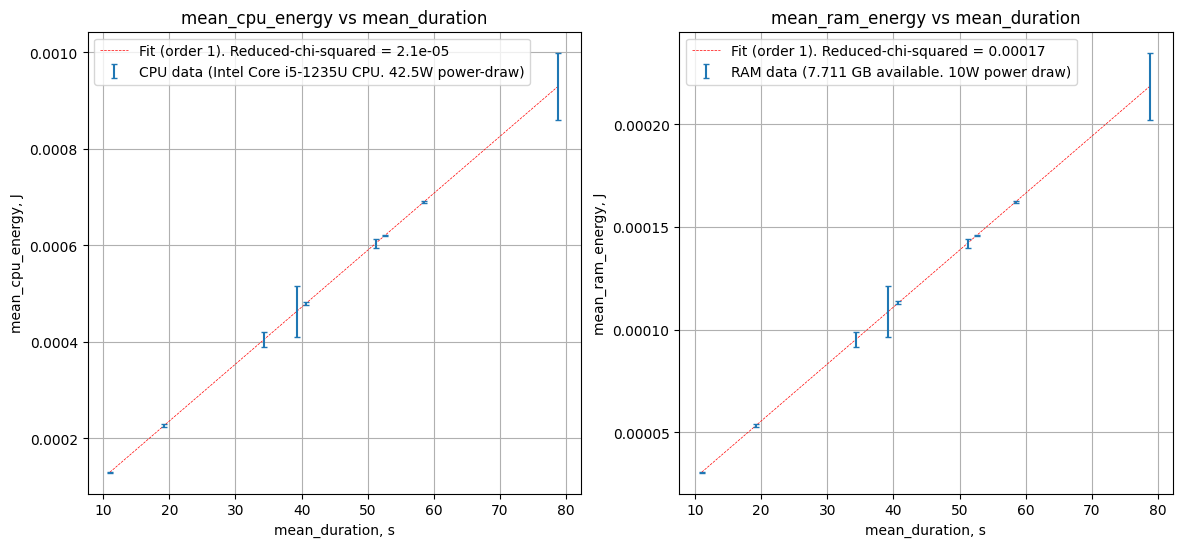

In [409]:
CPU_and_RAM_plotting(df, "mean_duration", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)

Now, lets demonstrate how CPU and RAM energy change with simulation intensity, by plotting average energy (J) consumption vs neutron number.

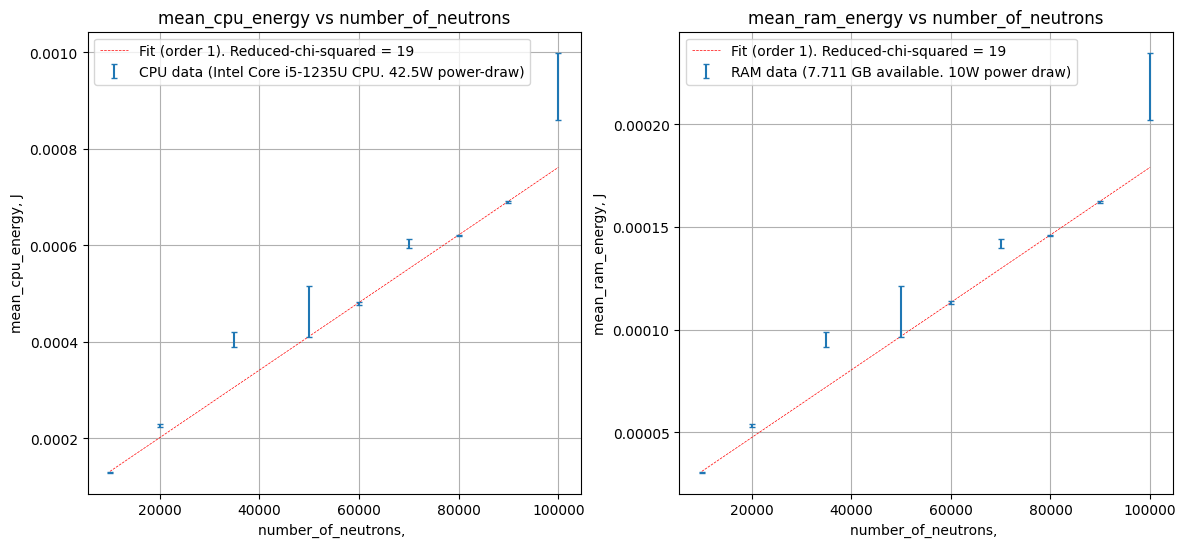

In [410]:
CPU_and_RAM_plotting(df, "number_of_neutrons", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)

Now, we will investigate the mean energy consumption of CPU/RAM per neutron simulated, with respect to the number of neutrons simulated at once. For fewer neutrons, the overhead involved with loading libraries and starting up the simulation is a relatively larger proportion of the energy consumption. However, as the number of neutrons simulated increases, this overhead is 'spread' over more neutrons, and is less significant when divided up amongst all of the neutrons. For a large enough number of neutrons, the overhead becomes negligible, and the energy consumption per neutron will start to plateau.

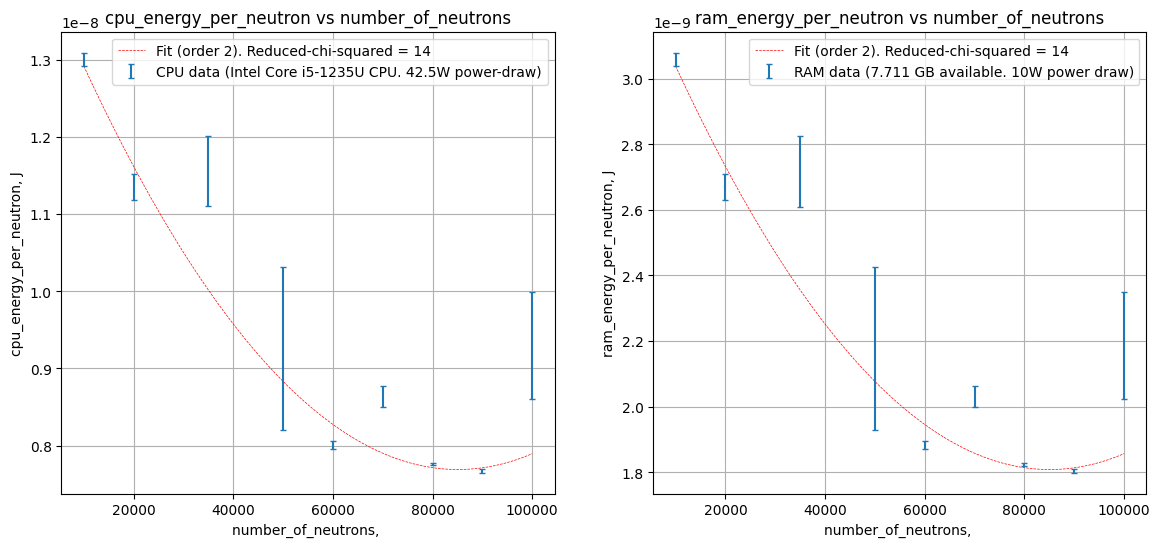

In [411]:
CPU_and_RAM_plotting(df, "number_of_neutrons", 
                    "cpu_energy_per_neutron", "cpu_energy_per_neutron_err", 
                    "ram_energy_per_neutron", "ram_energy_per_neutron_err", 
                    True, 2)

# 2.2 Power consumption

Here we will demonstrate that power consumption remains constant with time, by plotting CPU and RAM power (W) draw vs simulation duration (s).

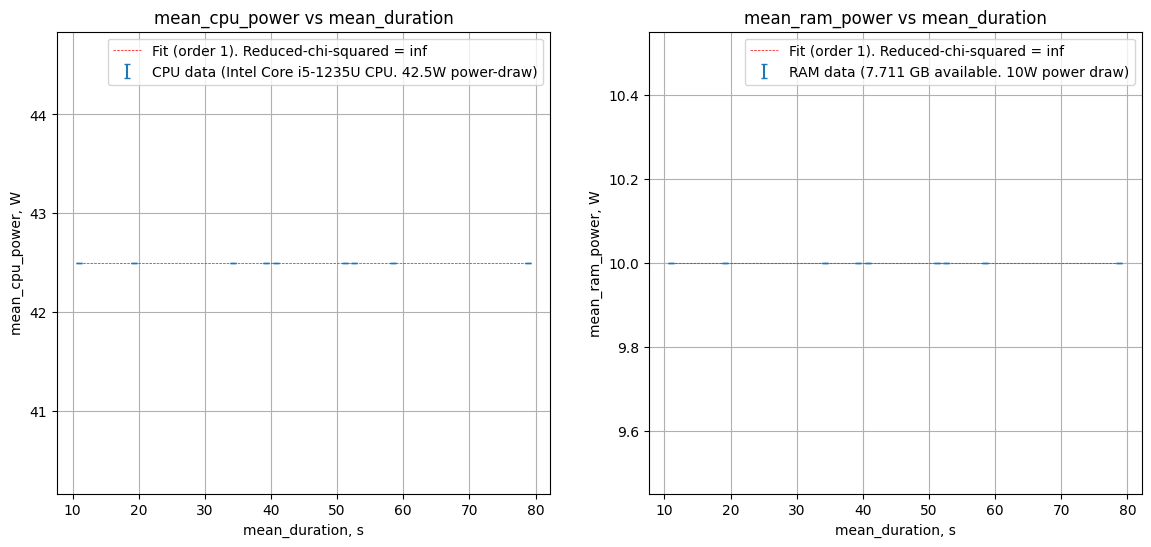

In [412]:
CPU_and_RAM_plotting(df, "mean_duration",
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)

Now, we can demonstrate how CPU/RAM power changes with simulation intensity (neutron number). 

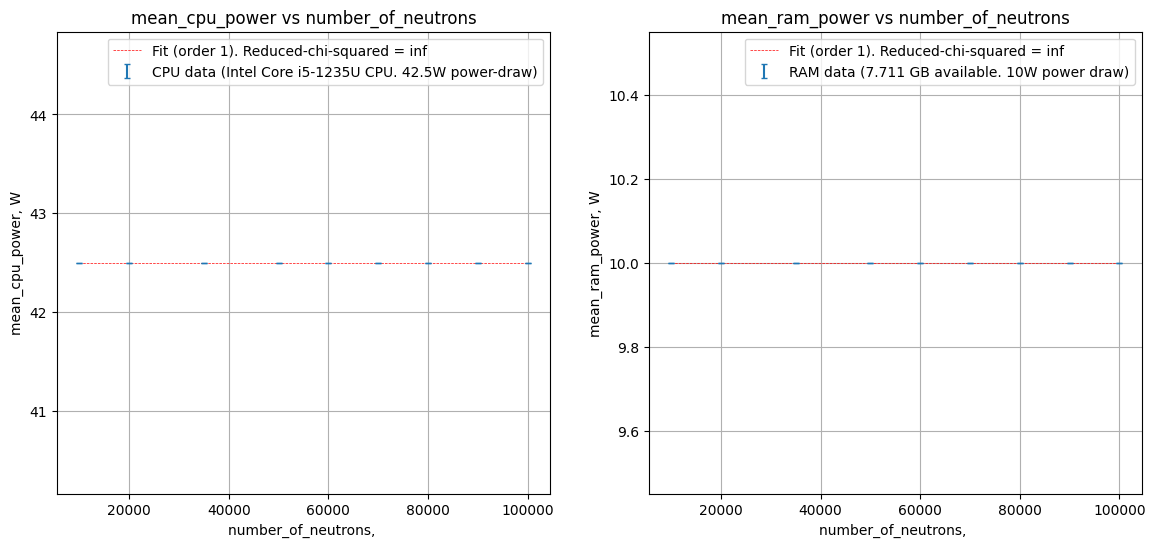

In [413]:
CPU_and_RAM_plotting(df, "number_of_neutrons", 
                    "mean_cpu_power", "cpu_power_err", 
                    "mean_ram_power", "ram_power_err", 
                    True, 1)

# 2.4 Emissions
Here we will plot how emissions change with respect to simulation complexity. The simulation emissions (gCO2e) are plotted with respect to neutron number.

In [414]:
def emissions_plotter(df, x_variable, fit=False, fit_order=None):
    """
    Creates plot of emissions vs x_variable, with optional polyfit.

    Parameters:
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable from df for plotting
    - fit: bool, whether or not a polyfit should be performed. Default=False
    - fit_order: int, order of polynomial fit if fit=True. Default=None
    """

    #plot emissions data
    plt.figure()
    plt.errorbar(df[x_variable], df['mean_emissions'], yerr=df['emissions_err'], fmt="none", capsize=2, label = "Emissions data. (CPU power = 42.5W. RAM power = 10W.)")
    
    #perform polyfit if fit=True
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        
        if np.any(df['emissions_err'])==0.0: #do not use error-weighted fitting is errors=0
            coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order)
        else: #use error-weighted fitting
            coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order, w=1/df['emissions_err'])

        #perform polyfit
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        #calculate reduced chi squared
        chi = reduced_chi_squared(df[x_variable], df['mean_emissions'], df['emissions_err'], coeffs)

        #plot fit
        plt.plot(x_fit, poly(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced chi squared = {chi:.2g}", linewidth = 0.5)

    #set x label based on x_variable
    if x_variable=='mean_duration': plt.xlabel(f'Simulation run-time, s')
    else: plt.xlabel(f'{x_variable}')

    #plot details
    plt.ylabel('Emissions, kgCO2e')
    plt.title(f'Mean Emissions vs {x_variable} of Simulation')
    plt.grid()
    plt.legend()
    plt.show()
    return None

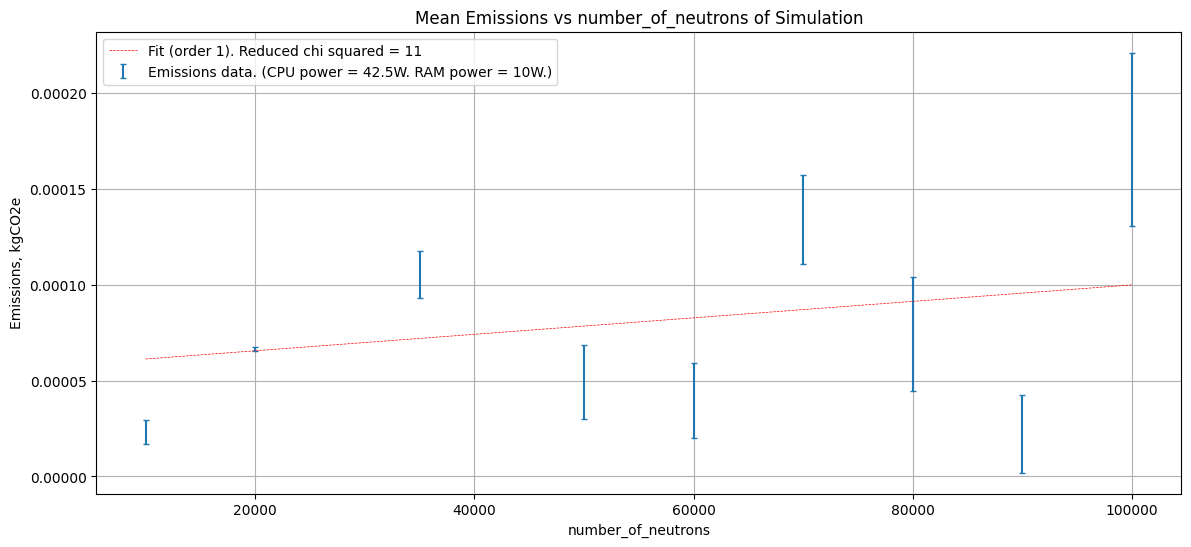

In [415]:
emissions_plotter(df, "number_of_neutrons", True, 1)

Now, we demonstrate how emissions change with runtime of simulation, by plotting the mean emissions (gCO2e) vs mean duration of simulation (s).

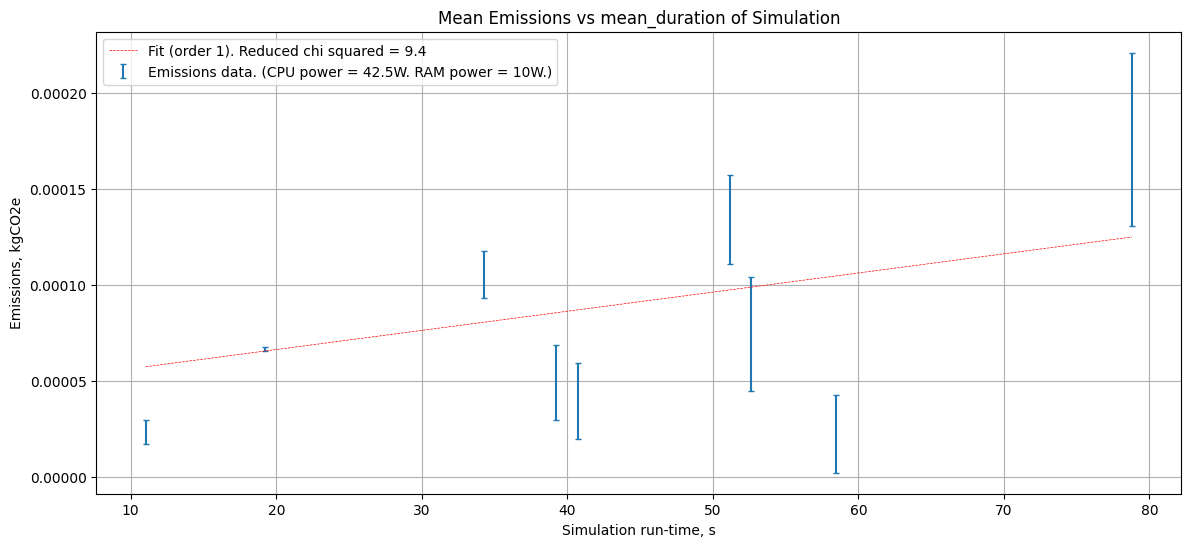

In [416]:
emissions_plotter(df, "mean_duration", True, 1)